In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from PIL import Image
import sys

In [26]:
#select the mode of panoptic
#set the path of picture/mask/label
panoptic_mode = int(input("Select the mode of panoptic: 1 for DETR, 2 for SETR: "))
if panoptic_mode == 1:
    Filepath = './DETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'
    
elif panoptic_mode == 2:
    Filepath = './SETR_result/'
    image1 = cv2.imread('image1.jpg')
    image2 = cv2.imread('image2.jpg')
    mask_label_path1 = Filepath + 'image1/'
    mask_label_path2 = Filepath + 'image2/'

Select the mode of panoptic: 1 for DETR, 2 for SETR:  1


In [57]:
# create a dictionary to store the mask and label and category
def read_masks_and_labels(mask_label_path):
    labels = []
    categories = []

    with open(mask_label_path + 'image_categories.txt', 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split(',')
            label = parts[0].split(':')[1].strip()
            category = parts[1].split(':')[1].strip()
            labels.append(int(label))
            categories.append(category)

    masks = []
    mask_dict = {}
    
    for i, ID in enumerate (labels):
        filename = 'mask_class_' + str(ID) + '.png'
        mask = cv2.imread(mask_label_path + filename, cv2.IMREAD_GRAYSCALE)
        masks = np.array(mask)
        mask_dict[i] = {'labels': labels[i], 'categories': categories[i], 'masks': masks}
        
    return mask_dict

# Use the function to read masks and labels
mask_dict1 = read_masks_and_labels(mask_label_path1)
mask_dict2 = read_masks_and_labels(mask_label_path2)

# print(mask_dict1)
# print('----------------')
# print(mask_dict2)

In [58]:
def rm_mask_label_lower_than_threshold(modified_dict, threshold):
    for key in list(modified_dict.keys()):
        mask = modified_dict[key]['masks']
        total_pixels = mask.size
        masked_pixels = np.sum(mask > 0)
        mask_percentage = (masked_pixels / total_pixels) * 100
        if mask_percentage < threshold:
            del modified_dict[key]
        rm_modified_dict = {}
        for i, key in enumerate(modified_dict.keys()):
            rm_modified_dict[i] = modified_dict[key]        
    return rm_modified_dict

rm_mask_dict1 = rm_mask_label_lower_than_threshold(mask_dict1, 5)
rm_mask_dict2 = rm_mask_label_lower_than_threshold(mask_dict2, 5)

# print(rm_mask_dict1)
# print('----------------')
# print(rm_mask_dict2)

In [59]:
def get_id_from_dict(mask_dict):
    ids = set()
    for i in range(len(mask_dict)):
        ids.add(mask_dict[i]['labels'])
    return ids

def invert_intersection_masks(modified_dict):
    # Stack and invert masks for the intersection
    if len(modified_dict) > 0:
        intersection_label = 99
        intersection_masks = np.stack([item['masks'] for item in modified_dict.values()])
        intersection_mask = np.bitwise_not(np.bitwise_or.reduce(intersection_masks, axis=0))
        modified_dict[len(modified_dict)] = {
            'labels': intersection_label,
            'categories': 'others',
            'masks': intersection_mask
        } 
    return modified_dict

def modified_dict_by_class(mask_dict1, mask_dict2):
    # Create sets to store the IDs of each dictionary
    ids_dict1 = get_id_from_dict(mask_dict1)
    ids_dict2 = get_id_from_dict(mask_dict2)

    # print(ids_dict1)
    # print(ids_dict2)
    
    # Create dictionaries to store matched and unmatched items
    same_dict1 = {}
    same_dict2 = {}
    counter1 = 0
    counter2 = 0
    
    # Process the first dictionary
    for key in mask_dict1:
        if mask_dict1[key]['labels'] in ids_dict2:
            same_dict1[counter1] = mask_dict1[key]
            counter1+=1
    
    # Process the second dictionary
    for key in mask_dict2:
        if mask_dict2[key]['labels'] in ids_dict1:
            same_dict2[counter2] = mask_dict2[key]
            counter2+=1

    modified_dict1 = {}
    modified_dict2 = {}
    
    modified_dict1 = invert_intersection_masks(same_dict1)
    modified_dict2 = invert_intersection_masks(same_dict2)
  
    return modified_dict1, modified_dict2

modified_dict1, modified_dict2 = modified_dict_by_class(rm_mask_dict1, rm_mask_dict2)
# modified_dict1, modified_dict2 = modified_dict_by_class(mask_dict1, mask_dict2)
# print(modified_dict1[0]['masks'].shape)
# print(modified_dict2[0]['masks'].shape)

In [60]:
#SIFT
#create the feature point
# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

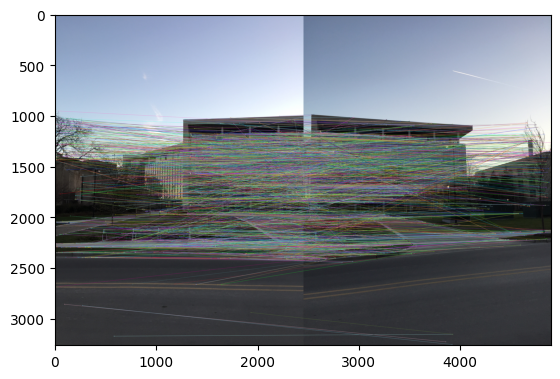

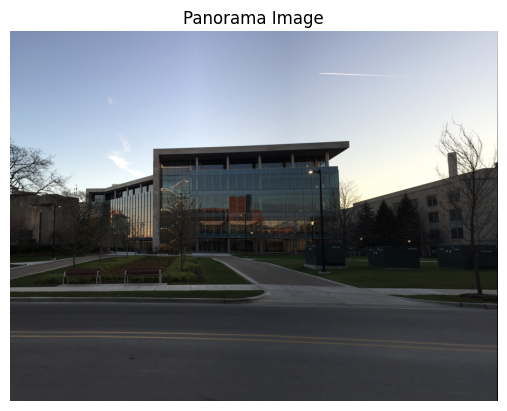

Panorama created successfully!


In [61]:
# 常量设置
RATIO = 0.85
MIN_MATCH = 10
SMOOTHING_WINDOW_SIZE = 800

def find_homography(kp1, kp2, good_points):
    """计算单应矩阵"""
    if len(good_points) > MIN_MATCH:
        image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
        image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
        H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 5.0)
        return H
    else:
        raise AssertionError("Can't find enough keypoints.") 

def create_mask(img1, img2, version):
    """创建拼接图像的平滑掩膜"""
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(SMOOTHING_WINDOW_SIZE / 2)
    barrier = img1.shape[1] - offset
    mask = np.zeros((height_panorama, width_panorama))
    if version == 'left_image':
        mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(1, 0, 2 * offset).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset:barrier + offset] = np.tile(np.linspace(0, 1, 2 * offset).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

def raw_matches_apply(raw_matches, len_des1, len_des2):
    for i, m in enumerate(raw_matches):
        raw_matches[i][0].queryIdx += len_des1
        raw_matches[i][0].trainIdx += len_des2
    return raw_matches

def blending(img1, img2):
    gray_img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray_img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    mask_len = max(len(modified_dict1), len(modified_dict2))
    kp1_sum = []
    des1_sum = []
    kp2_sum = []
    des2_sum = []
    raw_matches_sum = []

    sift = cv2.SIFT_create()
    
    for i in range(mask_len):
        mask_1 = modified_dict1[i]['masks']
        mask_1 = cv2.resize(mask_1, (img1.shape[1], img1.shape[0]))
        mask_2 = modified_dict2[i]['masks']
        mask_2 = cv2.resize(mask_2, (img2.shape[1], img2.shape[0]))
            
        kp1, des1 = sift.detectAndCompute(gray_img1, mask_1)
        kp2, des2 = sift.detectAndCompute(gray_img2, mask_2)

        matcher = cv2.BFMatcher()
        raw_matches = matcher.knnMatch(des1, des2, k=2)

        pre_des1 = len(des1_sum)
        pre_des2 = len(des2_sum)
        
        kp1_sum.extend(kp1)
        des1_sum.extend(des1)
        kp2_sum.extend(kp2)
        des2_sum.extend(des2)

        raw_matches = raw_matches_apply(raw_matches,pre_des1,pre_des2)
        raw_matches_sum.extend(raw_matches)

    good_points = []
    good_matches = []

    for m1, m2 in raw_matches_sum:
        if m1.distance < RATIO * m2.distance:
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])

    img3 = cv2.drawMatchesKnn(img1, kp1_sum, img2, kp2_sum, good_matches, None, flags=2)
    plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
    plt.show()

    H = find_homography(kp1_sum, kp2_sum, good_points)
        
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    
    panorama1 = np.zeros((height_panorama, width_panorama, 3))
    mask1 = create_mask(img1, img2, version='left_image')
    panorama1[0:img1.shape[0], 0:img1.shape[1], :] = img1
    panorama1 *= mask1
    mask2 = create_mask(img1, img2, version='right_image')
    panorama2 = cv2.warpPerspective(img2, H, (width_panorama, height_panorama)) * mask2
    result = panorama1 + panorama2
    
    rows, cols = np.where(result[:, :, 0] != 0)
    min_row, max_row = min(rows), max(rows) + 1
    min_col, max_col = min(cols), max(cols) + 1
    final_result = result[min_row:max_row, min_col:max_col, :]

    return final_result.astype(np.uint8)  # 确保数据类型为uint8

def main(argv1, argv2):
    img1 = cv2.imread(argv1)
    img2 = cv2.imread(argv2)
    final = blending(img1, img2)

    # Display the panorama using matplotlib
    final_rgb = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(final_rgb)
    plt.title('Panorama Image')
    plt.axis('off')
    plt.show()

# Example usage
try:
    main('image1.jpg', 'image2.jpg')
    print("Panorama created successfully!")
except IndexError:
    print("Please input two source images.")